# CSS5228 Final Project

In this notebook, we will start training our model.

In [26]:
# !pip install xgboost
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install optuna
# !pip install folium
# !brew install libomp

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from math import sqrt
import gc

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import cv

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from src.utils import highlight_top, save_fig

import warnings
warnings.filterwarnings("ignore")

# Configurations

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
sns.set_theme(style="ticks")
sns.set_context("paper", rc={"xtick.labelsize":15,
                             "ytick.labelsize":15,
                             "axes.titlesize":20,
                             "axes.labelsize":15})
default_col = '#4c72b0'
highlight_col = '#c44d52'

img_dir = Path("images/")

In [ ]:
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

# Import Data

In [ ]:
df_train = pd.read_csv("../clean_data/train_preproc.csv", index_col=0)
df_test = pd.read_csv("../clean_data/test_preproc.csv", index_col=0)
df_submission = pd.read_csv("../raw_data/example-submission.csv")

In [ ]:
df_train = df_train.drop(['property_type', 'subzone', 'planning_area'], axis=1)
df_test = df_test.drop(['property_type', 'subzone', 'planning_area'], axis=1)

In [ ]:
X = df_train.drop("price", axis=1)
y = df_train["price"]
df_test = df_test.loc[:, X.columns]

# 1. Baseline Performance

- We will start off with ensemble tree methods since it doesn't require standardization and performs relatively well.
- We will also be able to leverage on the feature importance function to have a sense of how each feature is performing

Try GridSearch

In [13]:
from xgboost import XGBRegressor, plot_importance
xgb = XGBRegressor(eval_metric='rmse')

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'subsample': [0.5], 'n_estimators': [1400], 
     'max_depth': [5], 'learning_rate': [0.02],
     'colsample_bytree': [0.4], 'colsample_bylevel': [0.5],
     'reg_alpha':[1], 'reg_lambda': [1], 'min_child_weight':[2]}
]
grid_search = GridSearchCV(xgb, param_grid, cv=3, verbose=1, scoring='neg_root_mean_squared_error')

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_valid)))
print(len(X_valid), len(y_valid))

Size of training set: 16076
Size of test: 4020
4020 4020


In [16]:
grid_search.fit(X_train, np.log(y_train));

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [17]:
# Top 5 hyper-parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values('rank_test_score')[:6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,17.746599,3.330136,0.15027,0.039122,0.5,0.4,0.02,5,2,1400,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.132774,-0.122672,-0.132756,-0.129401,0.004758,1


In [18]:
grid_search.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.4,
 'learning_rate': 0.02,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 1400,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.5}

In [19]:
print("RMSLE on training data:",round(-grid_search.score(X_train, np.log(y_train)),4))
print("RMSLE on validation data:",round(-grid_search.best_score_,4))

RMSLE on training data: 0.1072
RMSLE on validation data: 0.1294


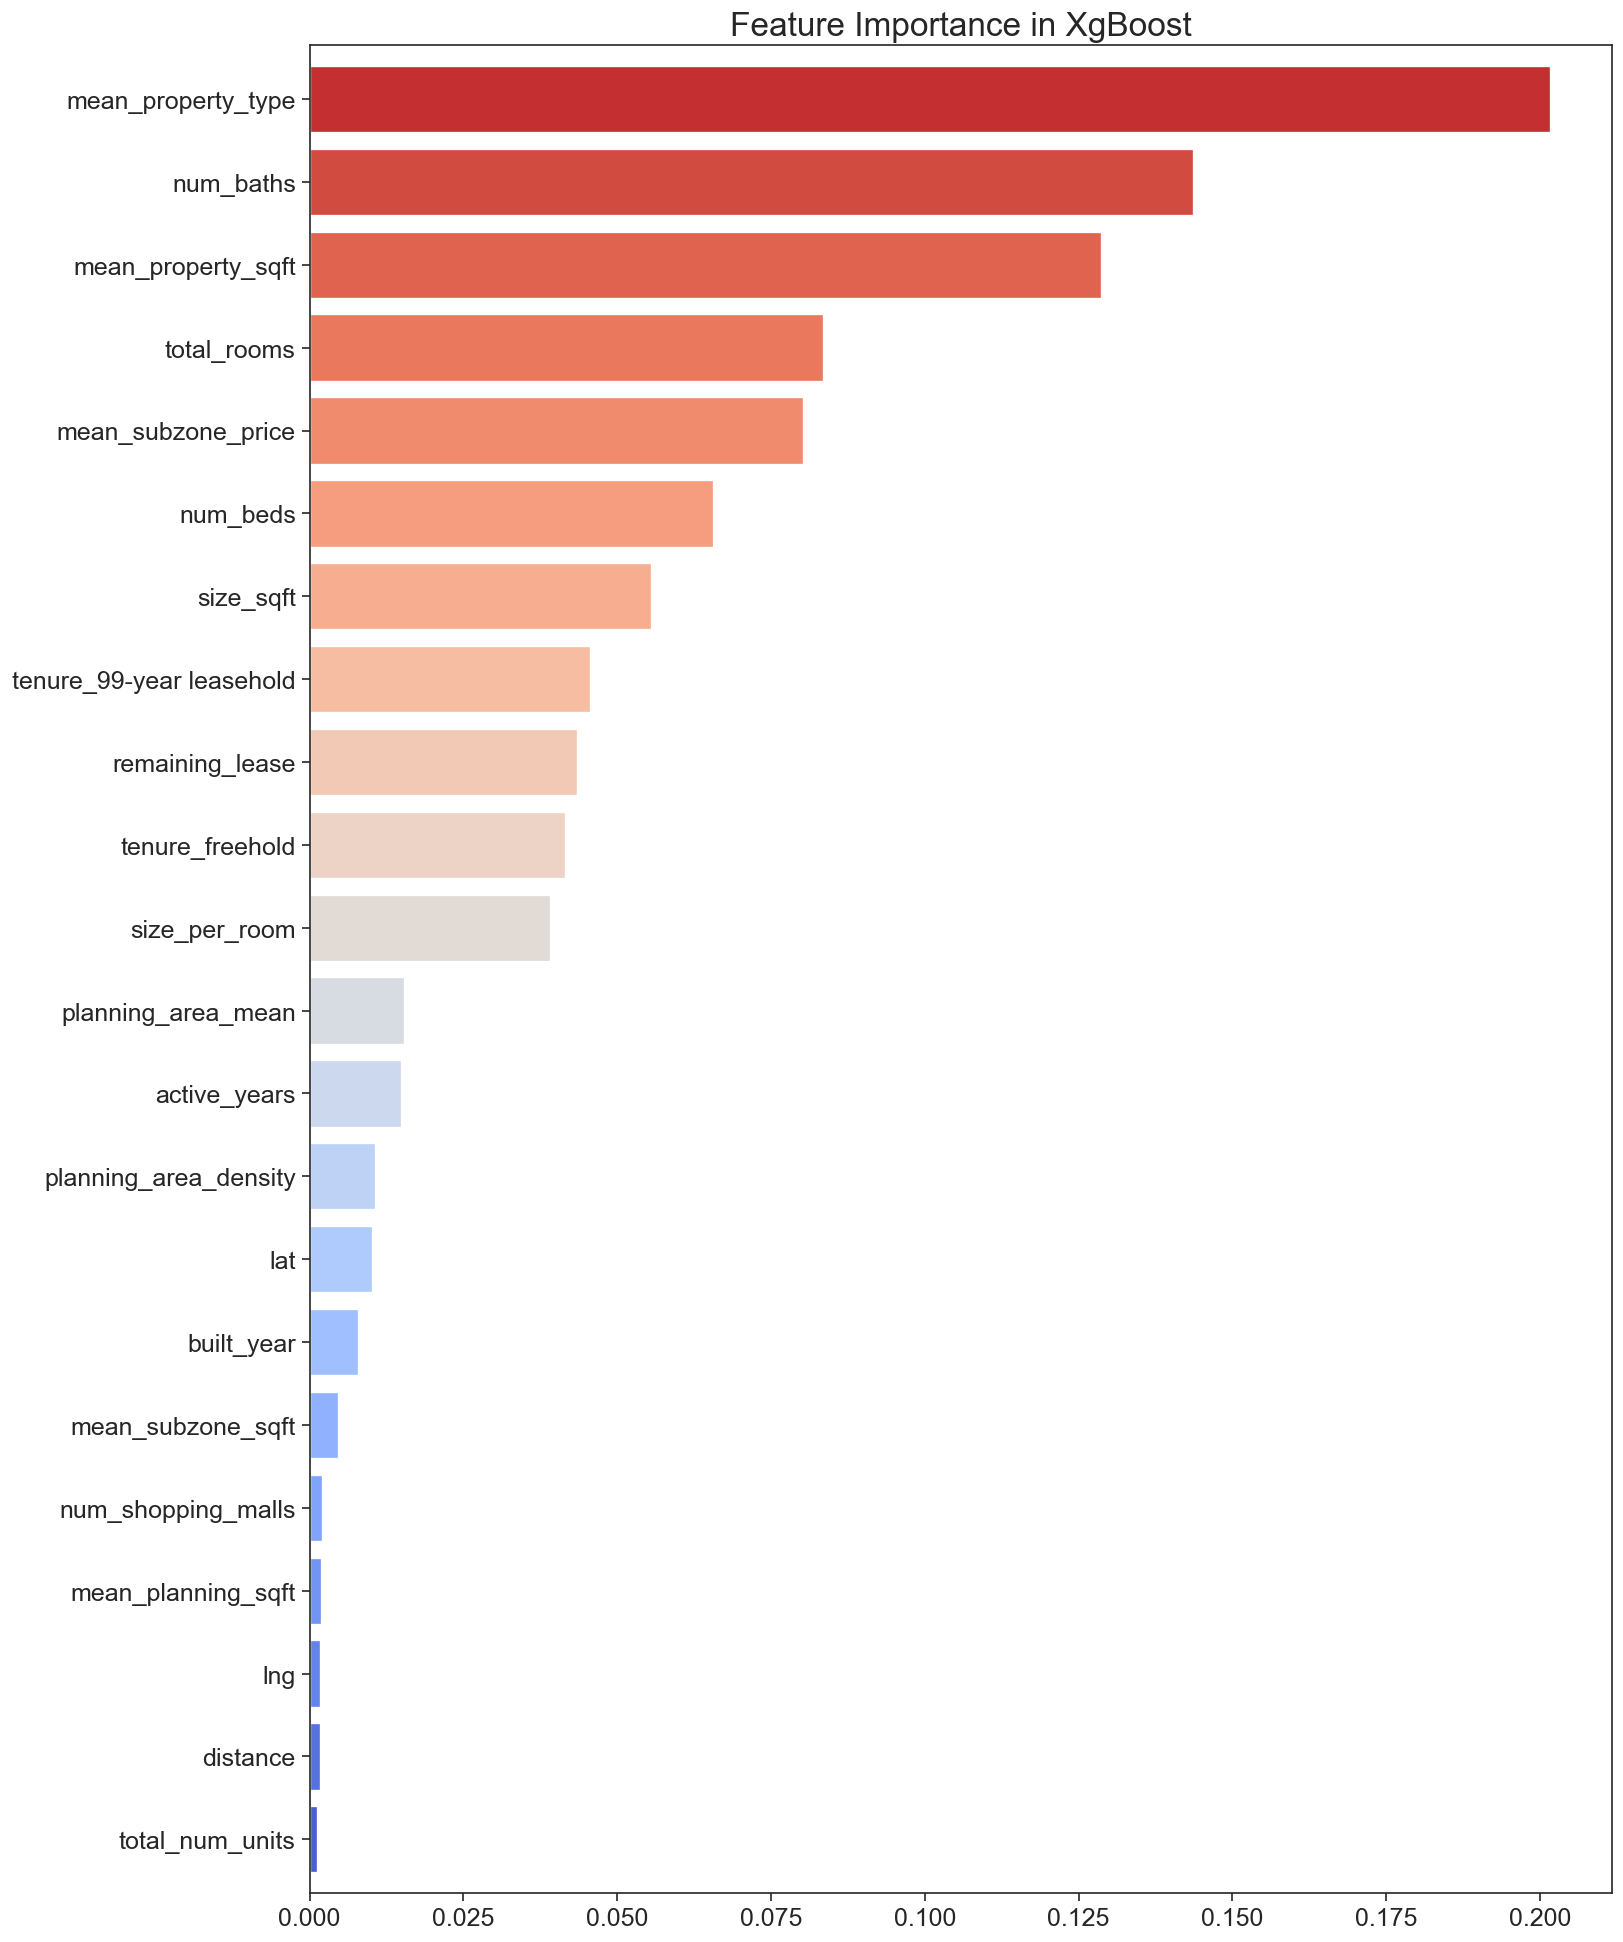

In [20]:
Feature_Imp = grid_search.best_estimator_.feature_importances_
Feature_Imp_sorted_series = pd.Series(Feature_Imp,X.columns).sort_values(ascending=True)

# Plot horizaontal bar plot
plt.figure(figsize=(14,20), dpi=120)
palette = sns.color_palette("coolwarm", len(X.columns)).as_hex()
ax = Feature_Imp_sorted_series.plot.barh(width=0.8 ,color=palette)
ax.set_title('Feature Importance in XgBoost')
plt.show()

In [21]:
y_preds = np.exp(grid_search.predict(df_test))

In [22]:
y_preds

array([1148822.9, 1479258.1, 1157599.1, ..., 3620578.2,  527927.3,
       4049881.2], dtype=float32)

In [23]:
df_submission = pd.DataFrame({'Id': df_test.index,
                       'Predicted': y_preds.round()})

In [24]:
df_submission = df_submission.loc[:,["Id", "Predicted"]]

In [25]:
df_submission.to_csv("submissions/train_xg_tune_model.csv", index=0)